# Introduction to NLP: Topic Modeling

-----

When analyzing large text corpora, trends can appear. These trends can be repeated use of common phrases or terms that are indicative of common underlying themes or topics. For example, books on programming might refer to themes such as human computer interaction, optimization and performance, or identifying and removing error conditions. Finding these common topics can be important for a number of reasons. On the one hand, when they are completely unknown, they can be used to provide new insight into text documents. On the other hand, when they may be partially or even completely unknown, computationally identified topics can provide deeper or more concise insight into the relationship between documents.

The process of identifying these common topics is known as topic modeling, which is generally a form of unsupervised learning. As a specific example, consider the [twenty newsgroup][tw] data that we have analyzed in scikit learn. While there are twenty different newsgroups, it turns out they can be grouped into six related categories: computers, sports, science, politics, religion, and miscellaneous. While we now these topics ahead of time (from the newsgroup titles), we can apply topic modeling to these data to identify the common words or phrases that define these common topics.

In the rest of this notebook, we explore the concept of topic modeling. First we will use the scikit learn library to perform topic modeling. We will introduce and use non-negative matrix factorization and Latent Dirichlet allocation. We apply topic modeling to a text classification problem, and also explore the terms that make up identified topics. Finally, we introduce the gensim library, which provides additional techniques for topic modeling.

-----

[tw]: http://qwone.com/~jason/20Newsgroups/

## Table of Contents

[Data Access](#Data-Access)

[Non-Negative Matrix Factorization](#Non-Negative-Matrix-Factorization)

- [Understanding Topic Terms](#Understanding-Topic-Terms)
- [Topic-Based Classification](#Topic-Based-Classification)

[Latent Dirichlet Allocation](#Latent-Dirichlet-Allocation)

[Gensim](#Gensim)

- [Topic Modeling with Gensim](#Topic-Modeling-with-Gensim)
- [Newsgroup Topic Modeling with Gensim](#Newsgroup-Topic-Modeling-with-Gensim)
- [Latent Semantic Analysis with Gensim](#Latent-Semantic-Analysis-with-Gensim)
- [Latent Dirichlet Allocation with Gensim](#Latent-Dirichlet-Allocation-with-Gensim)

-----

Before proceeding with the rest of this notebook, we first include the notebook setup code and we define our _home_ directory.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# First we find our HOME directory
home_dir = !echo $HOME

# Define data directory
home = home_dir[0] +'/'

-----

[[Back to TOC]](#Table-of-Contents)

## Data Access

To introduce topic modeling, we will use the twenty newsgroup data set, which is included with the scikit learn library. The following Code cell loads these data into the notebook and splits them into training and testing samples. The second Code cell applies a TF-IDF vectorizer to tokenize these documents to create a suitable document-term matrix. The vectorize uses and _english_ vocabulary, transforms all words to lowercase, requires terms to appear in at least two documents, and restricts the total number of features to be 5000.

-----

In [3]:
# Load Dataset
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(data_home=home + 'textdm', 
                           subset='train', shuffle=True, random_state=23,
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(data_home=home + 'textdm', 
                          subset='test', shuffle=True, random_state=23,
                          remove=('headers', 'footers', 'quotes'))

In [4]:
# Use TD-IDF on newgroup data.
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(stop_words = 'english',
                     lowercase=True,
                     min_df=2,
                     max_features=5000)
                     
train_data = cv.fit_transform(train['data'])
test_data = cv.transform(test['data'])

-----

[[Back to TOC]](#Table-of-Contents)

## Non-Negative Matrix Factorization

We can apply [non-negative matrix factorization][wnmf] (NMF) to compute topics in a corpus. We start with a term-document matrix, which we factor in to a term-feature and a feature-document matrices. The latter matrix can be used to identify data clusters (or topics) in the corpus. We demonstrate the use of NMF to perform topic modeling by using the scikit learn library's [NMF implementation][sknmf]. 

-----

[wnmf]: https://en.wikipedia.org/wiki/Non-negative_matrix_factorization
[sknmf]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [5]:
# Compute topics by using NMF
from sklearn.decomposition import NMF

# Pick six topics
num_topics = 6
nmf = NMF(n_components = num_topics, max_iter = 1000).fit(train_data)

In [6]:
from helper_code import tpterms as tp

nmf_topics = tp.get_topics(cv, nmf)

Topic  0: don just think people like good time know did right
Topic  1: thanks windows does know file mail program files advance use
Topic  2: god jesus bible believe faith christian christ christians people does
Topic  3: geb edu dsl chastity n3jxp cadre pitt shameful intellect skepticism
Topic  4: key chip encryption clipper keys government use escrow law public
Topic  5: drive scsi card disk hard drives controller ide new sale


-----

[[Back to TOC]](#Table-of-Contents)


### Understanding Topic Terms

We can explore the terms that are important for each topic by creating a DataFrame to map our topic terms to the original twenty newsgroups. We demonstrate this below by first normalizing the transformed data to have unit probability. We use these data to create the DataFrame and group the resulting rows by the associated newsgroup as shown below.

-----

In [7]:
# We transform and normalize the data, 
# by using l1-norm so document topic probabilty sums to unity.

from sklearn.preprocessing import normalize

td = nmf.transform(train_data)
td_norm = normalize(td, norm='l1', axis=1)

In [8]:
# We use a DataFrame to simplify the collecting of the data for display.
df = pd.DataFrame(td_norm, columns=nmf_topics)
df.fillna(value=0, inplace=True)
df['label'] = pd.Series(train['target'])

In [9]:
# Now group and add human names for the labels
df_lbl = df.groupby('label').mean()
df_lbl['Names'] = pd.Series(train['target_names'], dtype="category")

# Now display the grouped data
df_lbl

,"don, just, think, people, like","thanks, windows, does, know, file","god, jesus, bible, believe, faith","geb, edu, dsl, chastity, n3jxp","key, chip, encryption, clipper, keys","drive, scsi, card, disk, hard",Names
label,,,,,,,
0,0.427398,0.067956,0.381549,0.017617,0.056657,0.019657,alt.atheism
1,0.172845,0.557751,0.026722,0.020693,0.077724,0.113443,comp.graphics
2,0.111835,0.607817,0.017676,0.020599,0.047638,0.150442,comp.os.ms-windows.misc
3,0.115364,0.281958,0.022829,0.016014,0.059238,0.482562,comp.sys.ibm.pc.hardware
4,0.163281,0.246226,0.023568,0.014565,0.069813,0.444484,comp.sys.mac.hardware
5,0.130640,0.660720,0.027249,0.020968,0.103700,0.051664,comp.windows.x
6,0.182216,0.198290,0.020341,0.032627,0.048291,0.504561,misc.forsale
7,0.527202,0.134994,0.033273,0.020686,0.056815,0.169792,rec.autos
8,0.600778,0.136125,0.036220,0.025414,0.043300,0.131407,rec.motorcycles


-----

[[Back to TOC]](#Table-of-Contents)


### Topic-Based Classification

If documents are composed of topics, we can leverage defined topics to classify new documents based on the topics that are assigned to each new document. In the following Code cells, we first train a Naive Bayes classifier on the topics in the training data sample of the twenty newsgroup data set. We compute the topics, by using the previously created NMF model, for the test data and compute classifications from these topic models. Finally, the resulting classification report and confusion matrix are shown to demonstrate the quality of this classification method.

-----

In [10]:
# Build classifier from topics.
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(td, train['target'])

# Apply classifier to blind test data
ts_preds = clf.predict(nmf.transform(test_data))

from sklearn import metrics

print(metrics.classification_report(test['target'], ts_preds,
    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       319
           comp.graphics       0.00      0.00      0.00       389
 comp.os.ms-windows.misc       0.24      0.20      0.22       394
comp.sys.ibm.pc.hardware       0.27      0.49      0.35       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.27      0.66      0.38       395
            misc.forsale       0.33      0.03      0.06       390
               rec.autos       0.35      0.02      0.03       396
         rec.motorcycles       0.08      0.13      0.10       398
      rec.sport.baseball       0.04      0.00      0.00       397
        rec.sport.hockey       0.12      0.87      0.21       399
               sci.crypt       0.53      0.65      0.59       396
         sci.electronics       0.28      0.12      0.17       393
                 sci.med       0.14      0.04      0.06       396
         

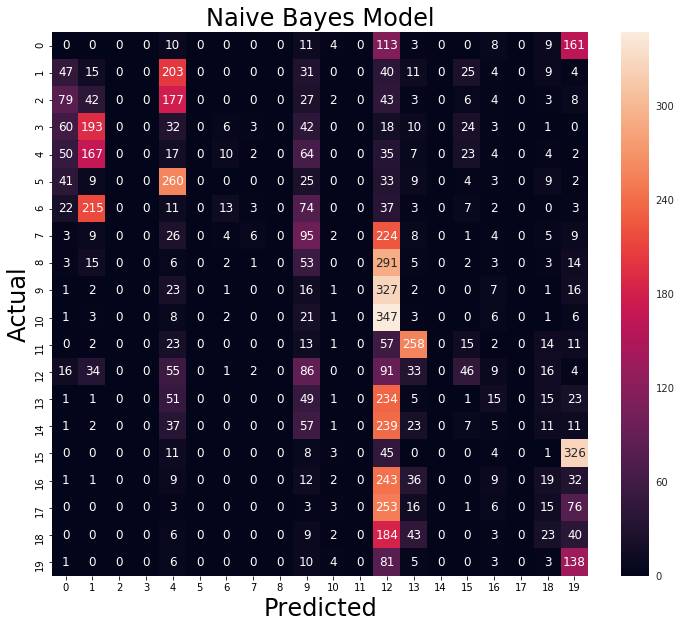

In [11]:
# Create Confusion Plot
fig, ax = plt.subplots(figsize=(12, 10))

from helper_code import mlplots as mp
mp.confusion(test['target'], ts_preds, range(20), 20, 'Naive Bayes Model')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we introduced basic topic modeling by using the scikit learn library and employed NMF in a text classification pipeline. Now that you have run the notebook, why do you think the results from the topic model-based classification are so poor, especially when compared to the same algorithm without topic modeling (feel free to discuss this in the class forum)?

Try making the following changes:

1. Increase the number of topics from six to sixty. Do the results change?
2. Change the classification algorithm to a random forest. Do the results change?
3. Try changing the TFIDF parameters to use more features and n-grams. Do the results change?

-----

[[Back to TOC]](#Table-of-Contents)



## Latent Dirichlet Allocation

Perhaps the most popular topic modeling algorithm is [Latent Dirichlet Allocation][wlda] or LDA. LDA assumes that documents in a Corpus result from a mixture of a small number of topics,  and that the words in the document can be attributed to one of the topics that make up that document. The scikit learn library has an [LDA implementation][sklda], which can be easily applied to a data set, as demonstrated below. After constructing an LDA model, we extract the topics (in this case we are identifying topics for the newsgroup data set) and display the top terms in each topic.

-----
[wlda]: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
[sklda]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5,
                                learning_method='online', learning_offset=5.,
                                random_state=23).fit(train_data)

In [13]:
lda_topics = tp.get_topics(cv, lda)

Topic  0: game team games year players season play hockey baseball league
Topic  1: people god don think just say believe know like did
Topic  2: ax eisa holes marc vax xdm disc dx _____ bu
Topic  3: thanks use know like does windows just new edu drive
Topic  4: bike car government gun just space clinton guns 000 year
Topic  5: msg chinese sphere plants sk mt ho pl p2 printf


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we introduced Latent Dirichlet Allocation. Now that you have run the notebook, try to use LDA in the previous text classification problem. Are the results better or worse? Can you explain why?

-----

[[Back to TOC]](#Table-of-Contents)


## Gensim

While NLTK is a useful library to learn the basic concepts in text analysis and natural language processing, there are other libraries that provide powerful NLP functionality. One of the most important libraries in this category is the [_gensim_ library][gl], which is an open source, Python library to create vector-space models for text data that can be used to create topic models. In the following section, we review how to use the gensim library to perform basic text analysis, before learning how to use gensim  to create topic models. 

An important task in gensim is to the creation of the vector space model for a text document. The indices into the vector space are mapped to the actual terms (or words) by a dictionary; thus we will need the actual vector space model and this dictionary to use gensim for topic modeling. These concepts are demonstrated in the following few Code cells, where we analyze the course description.

-----
[gl]: http://radimrehurek.com/gensim/

In [14]:
# Next section follows gensim tutorial

# As a text example, we use the following course description.
info_course = ['Advanced Data Science: This class is an asynchronous, ',
               'online course. This course will introduce advanced ',
               'data science concepts by building ',
               'on the foundational concepts presented in the ',
               'prerequisite course: Foundations of Data Science. ', 
               'Students will first learn how to perform more ',
               'statistical data exploration and constructing and ',
               'evaluating statistical models. Next, students will ',
               'learn machine learning techniques including supervised ',
               'and unsupervised learning, dimensional reduction, and ',
               'cluster finding. An emphasis will be placed on the ',
               'practical application of these techniques to ',
               'high-dimensional numerical data, time series data, ',
               'image data, and text data. Finally, students will ',
               'learn to use relational databases and cloud computing ',
               'software components such as Hadoop, Spark, and NoSQL ',
               'data stores. Students must have access to a fairly ',
               'modern computer, ideally that supports hardware ',
               'virtualization, on which they can install software.', 
               'This class is open to sophomores, juniors, seniors ',
               'and graduate students in any discipline who have ',
               'either taken a previous data science course or ',
               'have received instructor permission.']

# Simple stop words
stop_words = set('for a of the and to in on an'.split())

# Parse text into words, make lowercase and remove stop words
txts = [[word for word in sentance.lower().split() if word not in stop_words]
        for sentance in info_course]

# Keep only those words appearing more than once
# Easy with a Counter, but need a flat list
from collections import Counter
frequency = Counter([word for txt in txts for word in txt])

# Now grab tokens that appear more than once
tokens = [[token for token in txt if frequency[token] > 1]
          for txt in txts]

# Display the tokens
import pprint
pp = pprint.PrettyPrinter(indent=2, depth=2, width=80, compact=True)

pp.pprint(tokens)

[ ['advanced', 'data', 'this', 'class', 'is'],
  ['this', 'course', 'will', 'advanced'], ['data', 'science', 'concepts'],
  ['concepts'], ['data'], ['students', 'will', 'learn'],
  ['statistical', 'data'], ['statistical', 'students', 'will'],
  ['learn', 'techniques'], [], ['will'], ['techniques'], ['data,', 'data,'],
  ['data,', 'students', 'will'], ['learn'], [], ['data', 'students', 'have'],
  [], [], ['this', 'class', 'is'], ['students', 'have'],
  ['data', 'science', 'course'], ['have']]


In [15]:
# Compute a dictionary mapping for given text corpus

from gensim import corpora
dict_gensim = corpora.Dictionary(tokens)
print(dict_gensim)

Using TensorFlow backend.


Dictionary(15 unique tokens: ['advanced', 'data', 'this', 'class', 'is']...)


In [16]:
# Display mapping between index and word in Bag of Word model.

print(dict_gensim.token2id)

{'advanced': 0, 'data': 1, 'this': 2, 'class': 3, 'is': 4, 'course': 5, 'will': 6, 'science': 7, 'concepts': 8, 'students': 9, 'learn': 10, 'statistical': 11, 'techniques': 12, 'data,': 13, 'have': 14}


In [17]:
# Display sample text string as a bag of words.

new_txt = 'data science is cool, you should take this course to learn data concepts'
new_vec = dict_gensim.doc2bow(new_txt.lower().split())
pp.pprint(new_vec)

[(1, 2), (2, 1), (4, 1), (5, 1), (7, 1), (8, 1), (10, 1)]


In [18]:
# Display corpus as bag of words.

crps = [dict_gensim.doc2bow(txt) for txt in txts]
print(crps)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(0, 1), (2, 1), (5, 1), (6, 1)], [(1, 1), (7, 1), (8, 1)], [(8, 1)], [(1, 1)], [(6, 1), (9, 1), (10, 1)], [(1, 1), (11, 1)], [(6, 1), (9, 1), (11, 1)], [(10, 1), (12, 1)], [], [(6, 1)], [(12, 1)], [(13, 2)], [(6, 1), (9, 1), (13, 1)], [(10, 1)], [], [(1, 1), (9, 1), (14, 1)], [], [], [(2, 1), (3, 1), (4, 1)], [(9, 1), (14, 1)], [(1, 1), (5, 1), (7, 1)], [(14, 1)]]


-----

[[Back to TOC]](#Table-of-Contents)


### Topic Modeling with Gensim

We can use the gensim library to perform topic modeling. We first transform our info text document to a TFIDF model. The gensim library requires a dictionary to map indices into the TFIDF model to the words, which we can do with our `dict_gensim` object. In the next few Code cells, we first create our TFIDF document matrix, display the a sample text string, the bag of words model for this text strings, and the TFIDF model of this document. Next, we construct an Latent Dirichlet Allocation model of this document using our dictionary mapping object. Finally, we display the topics, before quantifying the top topic for each sentence in our original corpus.

-----

In [19]:
from gensim import models

tfidf = models.TfidfModel(crps)

In [20]:
# Print sentance, bago of words model, and TFIDF representation.

print(new_txt)
print(new_vec)

pp.pprint(tfidf[new_vec])

data science is cool, you should take this course to learn data concepts
[(1, 2), (2, 1), (4, 1), (5, 1), (7, 1), (8, 1), (10, 1)]
[ (1, 0.4282554571680886), (2, 0.32458258711331556), (4, 0.38919453737539955),
  (5, 0.38919453737539955), (7, 0.38919453737539955), (8, 0.38919453737539955),
  (10, 0.32458258711331556)]


In [21]:
# Compute LDA model for corpus

crps_tfidf = tfidf[crps]
lda_gs = models.LdaModel(corpus=crps_tfidf, id2word=dict_gensim, num_topics=3, passes=15)

In [22]:
# Display topics as functions over their top terms

lda_gs.print_topics(3)

[(0,
  '0.183*"will" + 0.171*"learn" + 0.135*"techniques" + 0.125*"statistical" + 0.116*"students" + 0.074*"data," + 0.024*"data" + 0.022*"course" + 0.022*"have" + 0.022*"concepts"'),
 (1,
  '0.192*"data" + 0.179*"have" + 0.125*"concepts" + 0.104*"science" + 0.090*"students" + 0.080*"data," + 0.061*"course" + 0.022*"statistical" + 0.021*"will" + 0.021*"techniques"'),
 (2,
  '0.160*"this" + 0.133*"class" + 0.133*"is" + 0.130*"advanced" + 0.086*"course" + 0.057*"will" + 0.050*"data" + 0.032*"data," + 0.031*"students" + 0.031*"techniques"')]

In [23]:
# Determine primary topic for each sentance in original text
import operator

for idx, txt in enumerate(lda_gs[crps_tfidf]):
    srt_txt = sorted(txt, key=operator.itemgetter(1))
    print(f'Sentance {idx:2d} has primary topic {srt_txt[-1][0]:1d} ', end='')
    print(f'with probability = {srt_txt[-1][1]:4.3f}')

Sentance  0 has primary topic 2 with probability = 0.762
Sentance  1 has primary topic 2 with probability = 0.733
Sentance  2 has primary topic 1 with probability = 0.750
Sentance  3 has primary topic 1 with probability = 0.665
Sentance  4 has primary topic 1 with probability = 0.663
Sentance  5 has primary topic 0 with probability = 0.749
Sentance  6 has primary topic 0 with probability = 0.515
Sentance  7 has primary topic 0 with probability = 0.746
Sentance  8 has primary topic 0 with probability = 0.722
Sentance  9 has primary topic 2 with probability = 0.333
Sentance 10 has primary topic 0 with probability = 0.662
Sentance 11 has primary topic 0 with probability = 0.665
Sentance 12 has primary topic 1 with probability = 0.616
Sentance 13 has primary topic 0 with probability = 0.730
Sentance 14 has primary topic 0 with probability = 0.665
Sentance 15 has primary topic 2 with probability = 0.333
Sentance 16 has primary topic 1 with probability = 0.742
Sentance 17 has primary topic 2

In [24]:
ttps = lda_gs.top_topics(corpus=crps_tfidf)
idx = 0

for lst, val in ttps:
    print(f'Topic {idx}')
    print(35*('-'))
    idx += 1
    for i, z in lst:
        print(f'    {z:20s}: {i:5.4f}')
    print(35*('-'))

Topic 0
-----------------------------------
    this                : 0.1604
    class               : 0.1335
    is                  : 0.1335
    advanced            : 0.1298
    course              : 0.0856
    will                : 0.0571
    data                : 0.0500
    data,               : 0.0316
    students            : 0.0313
    techniques          : 0.0312
    statistical         : 0.0312
    concepts            : 0.0312
    learn               : 0.0312
    have                : 0.0312
    science             : 0.0312
-----------------------------------
Topic 1
-----------------------------------
    data                : 0.1916
    have                : 0.1787
    concepts            : 0.1252
    science             : 0.1038
    students            : 0.0902
    data,               : 0.0797
    course              : 0.0610
    statistical         : 0.0220
    will                : 0.0212
    techniques          : 0.0212
    learn               : 0.0211
    is            

-----

[[Back to TOC]](#Table-of-Contents)


### Newsgroup Topic Modeling with Gensim

We can use the gensim library to perform topic modeling of the twenty newsgroup data. We first need to transform a sparse matrix (as provided by the scikit learn library) into a gensim corpus. We also need to construct a vocabulary dictionary, which we can do by transforming the scikit learn `CountVectorizer` vocabulary into a dictionary that maps between `id` and the `word`. We demonstrate this transformation in the following Code cell for the newsgroup training data.

-----

In [25]:
from gensim import matutils as mat
from gensim import models as md
from gensim.corpora.dictionary import Dictionary

# transform sparse matrix into gensim corpus
td_gensim = mat.Sparse2Corpus(train_data, documents_columns=False)

# Build temporary dictionary from scikit learn vectorizer
# for use with gensim
tmp_dct = dict((idv, word) for word, idv in cv.vocabulary_.items())
dct = Dictionary.from_corpus(td_gensim, id2word=tmp_dct)

-----

[[Back to TOC]](#Table-of-Contents)


### Latent Semantic Analysis with Gensim

We can use the gensim library to perform [Latent Semantic Analysis][wlsa] or LSA; in gensim, however, this technique is called [Latent Semantic Indexing][glsi] (or LSI). LSA assumes that words with similar meanings will occur in close proximity. By leveraging this assumption, we can build and process a term document matrix. After processing, a cosine similarity can be used to identify words that are similar. This technique is applied in the following Code cell, where we build an LSA model with six topics from the newsgroup text. The topics are subsequently displayed as functions of the most important terms in each topic.

-----
[wlsa]: https://en.wikipedia.org/wiki/Latent_semantic_analysis
[glsi]: http://radimrehurek.com/gensim/models/lsimodel.html

In [26]:
# LSI

lsi = md.lsimodel.LsiModel(corpus=td_gensim, id2word=dct, num_topics=6)
lsi.print_topics()

[(0,
  '0.167*"don" + 0.164*"just" + 0.162*"like" + 0.161*"know" + 0.153*"people" + 0.138*"think" + 0.128*"does" + 0.115*"good" + 0.114*"use" + 0.110*"time"'),
 (1,
  '-0.256*"god" + 0.240*"windows" + 0.228*"thanks" + -0.189*"people" + 0.157*"card" + 0.147*"drive" + 0.125*"dos" + -0.115*"jesus" + 0.114*"mail" + 0.112*"file"'),
 (2,
  '0.485*"god" + 0.181*"jesus" + 0.160*"windows" + 0.144*"does" + 0.130*"thanks" + -0.123*"year" + -0.118*"pitt" + -0.118*"geb" + 0.117*"bible" + -0.117*"game"'),
 (3,
  '0.265*"edu" + 0.237*"geb" + 0.235*"dsl" + 0.235*"cadre" + 0.235*"n3jxp" + 0.235*"chastity" + 0.234*"shameful" + 0.233*"skepticism" + 0.233*"intellect" + 0.233*"pitt"'),
 (4,
  '0.309*"key" + -0.238*"drive" + -0.219*"god" + 0.186*"government" + 0.175*"chip" + 0.173*"encryption" + 0.153*"clipper" + -0.144*"game" + 0.139*"use" + 0.131*"keys"'),
 (5,
  '0.428*"drive" + -0.277*"thanks" + 0.226*"scsi" + -0.156*"know" + -0.143*"game" + 0.135*"drives" + 0.132*"disk" + 0.129*"key" + -0.128*"mail" + 

-----

[[Back to TOC]](#Table-of-Contents)


### Latent Dirichlet Allocation with Gensim

The gensim library also provides an implementation of the [Latent Dirichlet allocation][glda] or LDA. We demonstrate the gensim LDA technique in the following Code cell, where we once again create an LDA model with six topics for the newsgroup text. We subsequently display the topics as functions of the top words within each topic. Finally, we display the top five words in each topic, along with their topic coherence, which is a measure of the words importance to the specific topic.

-----

[glda]: http://radimrehurek.com/gensim/models/ldamodel.html

In [27]:
# LDA

lda_gs = md.LdaModel(corpus=td_gensim, id2word=dct, num_topics=6, passes=2)
lda_gs.show_topics()

[(0,
  '0.006*"game" + 0.006*"team" + 0.005*"games" + 0.004*"year" + 0.004*"season" + 0.003*"00" + 0.003*"israel" + 0.003*"win" + 0.003*"10" + 0.003*"11"'),
 (1,
  '0.012*"key" + 0.008*"clipper" + 0.007*"keys" + 0.007*"chip" + 0.007*"encryption" + 0.005*"phone" + 0.005*"nsa" + 0.004*"algorithm" + 0.004*"just" + 0.004*"des"'),
 (2,
  '0.006*"thanks" + 0.006*"windows" + 0.005*"file" + 0.004*"use" + 0.004*"know" + 0.004*"program" + 0.004*"mail" + 0.004*"window" + 0.004*"does" + 0.004*"files"'),
 (3,
  '0.005*"people" + 0.005*"don" + 0.004*"just" + 0.004*"think" + 0.004*"god" + 0.004*"like" + 0.003*"know" + 0.003*"time" + 0.003*"good" + 0.003*"say"'),
 (4,
  '0.006*"nubus" + 0.005*"ncd" + 0.005*"francis" + 0.005*"germany" + 0.005*"cc" + 0.005*"stats" + 0.005*"hawks" + 0.005*"mit" + 0.005*"compuserve" + 0.004*"armenian"'),
 (5,
  '0.007*"drive" + 0.006*"scsi" + 0.005*"does" + 0.005*"card" + 0.004*"know" + 0.004*"just" + 0.004*"thanks" + 0.004*"use" + 0.004*"problem" + 0.003*"like"')]

In [28]:
ttps = lda_gs.top_topics(corpus=td_gensim)

In [29]:
idx = 0

for lst, val in ttps:
    print('Topic {0}'.format(idx))
    print(35*('-'))
    idx += 1
    for i, z in lst:
        print('    {0:20s}: {1:5.4f}'.format(z, i))
    print(35*('-'))

Topic 0
-----------------------------------
    people              : 0.0051
    don                 : 0.0045
    just                : 0.0039
    think               : 0.0039
    god                 : 0.0037
    like                : 0.0036
    know                : 0.0032
    time                : 0.0029
    good                : 0.0029
    say                 : 0.0029
    right               : 0.0026
    way                 : 0.0025
    believe             : 0.0024
    make                : 0.0024
    did                 : 0.0024
    really              : 0.0023
    does                : 0.0023
    said                : 0.0023
    ve                  : 0.0023
    government          : 0.0019
-----------------------------------
Topic 1
-----------------------------------
    key                 : 0.0124
    clipper             : 0.0076
    keys                : 0.0069
    chip                : 0.0068
    encryption          : 0.0067
    phone               : 0.0052
    nsa           

-----

<font color='red' size = '5'> Student Exercise </font>


In the preceding cells, we used the gensim library to perform topic modeling on the twenty newsgroup data set. Now that you have ran the notebook, try making the following changes.

1. Increase the number of topics, how do the results change?
2. Can you map the topics to the original newsgroups?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Blog article on [topic modeling][botm]
2. Wikipedia article on [Latent Dirichlet Allocation (LDA)][wlda] 
22. Wikipedia article on [Non-negative Matrix Factorization][wnmf] (focus on text-mining)
12. Tutorial on using gensim for [topic modeling][gtm] 
43. [Text Analysis with topic Models][tatm] for the Humanities and Social Sciences
101. Blog article on [matrix factorization][bnmf], with application to NMF

-----

[wlda]: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
[wtm]: https://en.wikipedia.org/wiki/Topic_model
[wnmf]: https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

[gtm]: http://radimrehurek.com/gensim/tut2.html
[tatm]: https://www.de.dariah.eu/tatom/index.html

[bnmf]: http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/

[botm]: https://www.oreilly.com/ideas/topic-models-past-present-and-future

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode